**Summary**
<br>We used the ufo sighting dataset to look at ufo sightings around the United States to see if there was any correlation between how long a sighting was and where it happened. By using code and libraries to map out the sightings, we also got a peek into whether there were any unusual clustering of sightings that couldn't be explained by a difference in population. In the end, we were unable to conclude that there was a difference in duration based on location and were also able to see that clustering in areas didn't show any unusual groupings that couldn't be explained by population differences.

**Introduction/Data Prep**
<br>The data used in this notebook was downloaded from https://www.kaggle.com/datasets/NUFORC/ufo-sightings. We used the scrubbed version of the file since it was already moderately cleaned. 

The main questions we were as follows:
1. Does duration of sighting have any correlation to the location where the sighting took place.
2. Are we able to look at the clustering on a map and see any abnormal clustering in areas that can't be explained by population differences? 

**Import Libraries**

In [2]:
# general import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
# cluster imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
# mapping specific imports
import folium 
from branca.colormap import StepColormap

# read in file
ufodata = pd.read_csv('/content/ufodata.csv')

**Data Exploration and Visualization**

In [3]:
# a look at our columns and examples of data in columns
ufodata.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),date posted,latitude,longitude
0,5/22/1974 5:30,mescalero indian reservation,nm,NaN,rectangle,7200.0,two hours,4/18/2012,33.200088,-105.624152
1,4/7/2006 22:44,pond inlet (canada),nt,ca,circle,30.0,30 seconds,5/15/2006,72.700000,-78.000000
2,12/14/2004 23:30,pond inlet (canada),nt,ca,circle,15.0,10-15 seconds,1/11/2005,72.700000,-78.000000
3,7/29/2009 13:00,north of pt. barrow,ak,NaN,disk,2700.0,45 minutes,4/13/2010,71.387500,-156.481111
4,29753,point barrow,ak,NaN,cylinder,300.0,less than 5 min.,9/28/2003,71.387500,-156.481111


In [4]:
# a look at the columns and datatypes
ufodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35988 entries, 0 to 35987
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              35988 non-null  object 
 1   city                  35988 non-null  object 
 2   state                 32680 non-null  object 
 3   country               31740 non-null  object 
 4   shape                 34968 non-null  object 
 5   duration (seconds)    35988 non-null  float64
 6   duration (hours/min)  35988 non-null  object 
 7   date posted           35988 non-null  object 
 8   latitude              35988 non-null  float64
 9   longitude             35988 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [5]:
ufodata.describe(include='all')

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),date posted,latitude,longitude
count,35988,35988,32680,31740,34968,3.598800e+04,35988,35988,35988.000000,35988.000000
unique,32600,10289,59,4,27,NaN,4734,315,NaN,NaN
top,11/16/1999 19:00,seattle,wa,us,light,NaN,5 minutes,12/12/2009,NaN,NaN
freq,22,524,4264,26730,7553,NaN,2094,693,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.132608e+04,NaN,NaN,44.648315,-84.232122
std,NaN,NaN,NaN,NaN,NaN,7.974495e+05,NaN,NaN,4.190054,33.545945
min,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,NaN,33.200088,-176.658056
25%,NaN,NaN,NaN,NaN,NaN,3.000000e+01,NaN,NaN,41.595000,-111.888771
50%,NaN,NaN,NaN,NaN,NaN,1.800000e+02,NaN,NaN,43.190000,-84.248333
75%,NaN,NaN,NaN,NaN,NaN,6.000000e+02,NaN,NaN,46.872222,-73.810000


In [6]:
# Counts by Country and State
print('Count by Country:')
print(ufodata['country'].value_counts())
print()
print('Count by State:')
print(ufodata['state'].value_counts())

Count by Country:
us    26730
ca     3000
gb     1905
de      105
Name: country, dtype: int64

Count by State:
wa    4264
ny    3218
il    2143
mi    2071
pa    1873
or    1842
on    1583
ma    1355
wi    1333
oh    1258
mn    1081
ct     962
nj     947
bc     786
ia     707
in     667
me     632
ut     567
id     553
nh     534
mt     510
ne     399
ak     352
ca     348
ab     333
vt     307
ri     289
co     241
wy     202
sd     196
qc     178
mb     154
ns     141
nd     138
nb     116
sk      97
pq      90
nv      66
sa      28
nf      24
nt      17
pe      16
wv      14
mo      14
yt      11
yk       7
de       3
nc       2
ga       1
md       1
hi       1
nm       1
ar       1
tn       1
fl       1
va       1
la       1
ms       1
az       1
Name: state, dtype: int64


In [7]:
# Blank Country and State fields that we are dealing with.
print('Blank Country: ' + str(ufodata['country'].isnull().values.sum()))
print('Blank State: ' + str(ufodata['state'].isnull().values.sum()))

Blank Country: 4248
Blank State: 3308


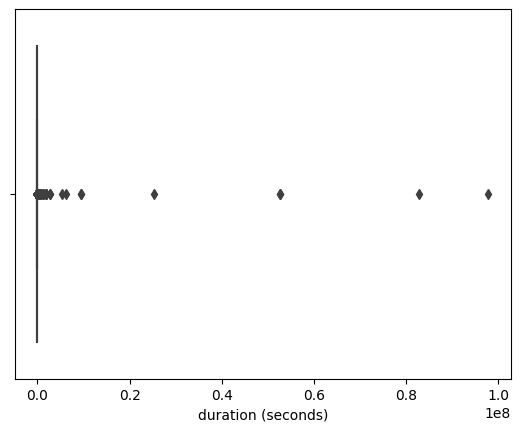

97835999.99
30.0
600.0
570.0



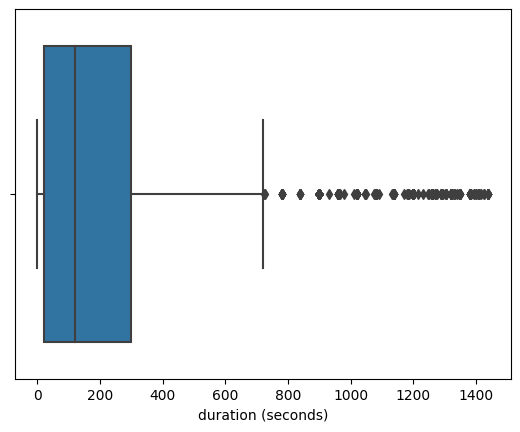

In [8]:
# plot out the duration to get a good view of our outliers.
sns.boxplot(x=ufodata["duration (seconds)"])

# Format y-axis labels in non-scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

# Show the plot
plt.show()
# -------------------------------------------------------

column_range=ufodata['duration (seconds)'].max()-ufodata['duration (seconds)'].min()
print(column_range)
# First Quartile - 25% of the values are below this cutoff
q1 = ufodata['duration (seconds)'].quantile(.25)
print(q1)

# Third Quartile - 75% of the values are below this cutoff
q3 = ufodata['duration (seconds)'].quantile(.75)
print(q3)

# Inter Quartile Ratio - range of the middle 50% - less likely to be influenced by outliers
iqr=q3-q1
print(iqr)
print()


# Remove outliers for better visual on what it looks like with/without outliers on box and whisker (used info from https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html and previous assignment)
q1 = ufodata['duration (seconds)'].quantile(0.25)
q3 = ufodata['duration (seconds)'].quantile(0.75)
iqr = q3 - q1
ufodata = ufodata[(ufodata['duration (seconds)'] > (q1 - 1.5 * iqr)) & (ufodata['duration (seconds)'] < (q3 + 1.5 * iqr))]  

# Create box and whisker plot
sns.boxplot(x=ufodata["duration (seconds)"])

# Format y-axis labels in non-scientific notation (used a combination of this link https://www.geeksforgeeks.org/matplotlib-axis-axis-set_major_formatter-function-in-python/ and pretty much the opposite of what was done in this link https://www.geeksforgeeks.org/matplotlib-axis-axis-set_major_formatter-function-in-python/)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

# Show the plot
plt.show()

**Data Preparation**
<br>We did need to do some additional manual cleaning outside of code to get the csv file to read in properly. We decided not to use the comments column as we are not doing any kind of text analysis in this project. Also 3 cells in the 'duration (seconds)' column had apostrophes so we were able to correct this typo. Latitude also had one entry with an accidental 'q' typed into number. Looked up latitude/longitude of location
and entry matched actual lat/long minus the entered 'q'. We removed the 'q' for alignment of data.
<br>
<br>Columns Dropped:
<br>comments - No text analysis being done.
<br>duration (hours/min) - unreliable/unpredicatable formats. used duration(seconds) instead.
<br>date posted - the date the sighting was posted was not relevant to what we were trying to prove in this project.
<br>shape - the shape of the ufo ended up not being relevant to our project.
<br>
<br>Although we did not use city, state, and country due to the inconsistency in the way the country was filled out, we did find it useful to use as a sorting tool to filter what we would use. We ended up narrowing the sightings down to the continental US, Alaska, Hawaii, DC, and Puerto Rico. We were able to use code to fill in the states that were missing if they had their state value which ended up letting us keep in an additional values that we would have otherwise lost when filtering out non-US sightings. We also had to edit the file in a separate csv editing program than excel as excel would save the dates in excel serial number format and cause the dates to read in as an object rather than an int or float.

In [9]:
# dropping unneeded fields
ufodata = ufodata.drop('date posted', axis = 1)
ufodata = ufodata.drop('duration (hours/min)', axis = 1)


In [10]:
print(ufodata.isnull().sum()) #count of empty values in each field

# There's also a large number of missing entries for state and country
# There were also dropped values because us was missing in several of the states. We remedied this by iterating through the ones that have a state value and adding us into the country field below. This kept us from losing approx 5000 entries
for index, row in ufodata.iterrows():
    # check if the country field is blank and the state field contains a valid state abbreviation
    if pd.isna(row['country']) and str(row['state']).lower() in ['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']:
        # fill in the country field with 'us'
        ufodata.at[index, 'country'] = 'us'

ufodata = ufodata[ufodata['country'] == "us"]
print()
print(ufodata.isnull().sum()) #recount of empty values

datetime                 0
city                     0
state                 2956
country               3627
shape                  862
duration (seconds)       0
latitude                 0
longitude                0
dtype: int64

datetime                0
city                    0
state                   0
country                 0
shape                 753
duration (seconds)      0
latitude                0
longitude               0
dtype: int64


In [11]:
#initial count before removing outliers
print('Count of States: ', len(set(ufodata['state']))) # we get 52 unique entries. 50 states plus DC and puerto rico
print()
print('Count by State: ')
print(ufodata['state'].value_counts(dropna=False)) # checking for counts of above entries and checking for blanks

Count of States:  40

Count by State: 
wa    3795
ny    2830
il    1877
mi    1787
pa    1625
or    1622
ma    1198
wi    1158
oh    1092
mn     911
ct     835
nj     829
ia     624
in     577
me     539
ut     481
id     475
nh     467
mt     424
ne     344
ak     293
ca     289
vt     282
ri     260
co     216
sd     171
wy     170
nd     113
nv      54
wv      13
mo      13
de       2
hi       1
nc       1
ar       1
ga       1
md       1
fl       1
va       1
az       1
Name: state, dtype: int64


In [12]:
# Checking for effect of removing all other countries besides US on outliers
# IQR
q1 = ufodata['duration (seconds)'].quantile(0.25)
q3 = ufodata['duration (seconds)'].quantile(0.75)
iqr = q3 - q1
print('IQR: ',iqr)

# upper and lower bound
upper = q3 + 1.5 * iqr
print('Upper bound: ', upper)
lower = q1 - 1.5 * iqr
print('Lower bound: ', lower)

ufodata = ufodata[ufodata['duration (seconds)'] <= upper] #removing everything over the upper bound
# lower bound is negative and we have no negative values
print()
print(ufodata['duration (seconds)'].max())

IQR:  275.0
Upper bound:  712.5
Lower bound:  -387.5

705.0


In [13]:
# We decided to focus on the US, in part because the majority of the data is from here.
print('Count by Country:')
print(ufodata['country'].value_counts(dropna = False)) # added dropna = False to see if code missed any
print()
print('Count of States: ', len(set(ufodata['state']))) # we get 52 unique entries. 50 states plus DC and puerto rico
print()
print('Count by State: ')
print(ufodata['state'].value_counts(dropna=False)) # checking for counts of above entries and checking for blanks after removing outliers.

Count by Country:
us    22500
Name: country, dtype: int64

Count of States:  40

Count by State: 
wa    3392
ny    2484
mi    1610
il    1590
pa    1457
or    1456
ma    1065
wi    1013
oh     960
mn     828
ct     749
nj     733
ia     564
in     516
me     467
ut     427
id     416
nh     415
mt     377
ne     303
ca     266
vt     261
ak     241
ri     233
co     199
sd     155
wy     153
nd      97
nv      40
wv      12
mo      11
de       2
hi       1
nc       1
ar       1
ga       1
md       1
fl       1
va       1
az       1
Name: state, dtype: int64


**Modeling**

In [15]:
scaler = StandardScaler()
ufodata = pd.read_csv('/content/ufodata_prepped.csv')
# drop fields we won't be using in cluster model (not numerical)
ufodata_kmeans = ufodata.drop(columns=['datetime', 'city', 'state', 'country', 'shape'])
# Scaling the data for Cluster Model
col_names = list(ufodata_kmeans.columns)
ufodata_kmeans = pd.DataFrame(scaler.fit_transform(ufodata_kmeans), columns=col_names)
# We used a Scree Plot and determined 5 clusters was optimal. K-Means was used to fit the data to each cluster.
ufo_km_model = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_km = ufo_km_model.fit_predict(ufodata_kmeans)
# We then added the assigned clusters as a feature (column) to the dataset
ufodata_kmeans['cluster'] = y_km
print(ufodata_kmeans)

       duration (seconds)  latitude  longitude   cluster
0                1.936917 -0.561588    0.293782        2
1               -0.768014 -0.488960   -0.599409        1
2                0.286450 -0.020671    0.266333        0
3                0.103065  0.550220    1.201719        0
4               -0.447090 -1.369064    0.393861        4
...                   ...       ...         ...      ...
61484           -0.630475  0.392059   -0.360716        0
61485            2.853842  0.729778    1.023169        2
61486           -0.630475  0.928638   -1.232746        3
61487           -0.630475  0.538815    0.295592        0
61488           -0.630475  0.311248    0.509341        0

[61489 rows x 4 columns]


**Modeling Assumptions**
<br>For our data, we had no clear target. We were able to narrow our features to only a numerical set, reducing the number of dimensions in the process. We also did not find any multicollinearity in the remaining fields. These assumptions met the requirements for a K-Means cluster model.

**Visualization...**
<br>Since we had three features, we were able to build a 3d plot to create a visual of the clusters.

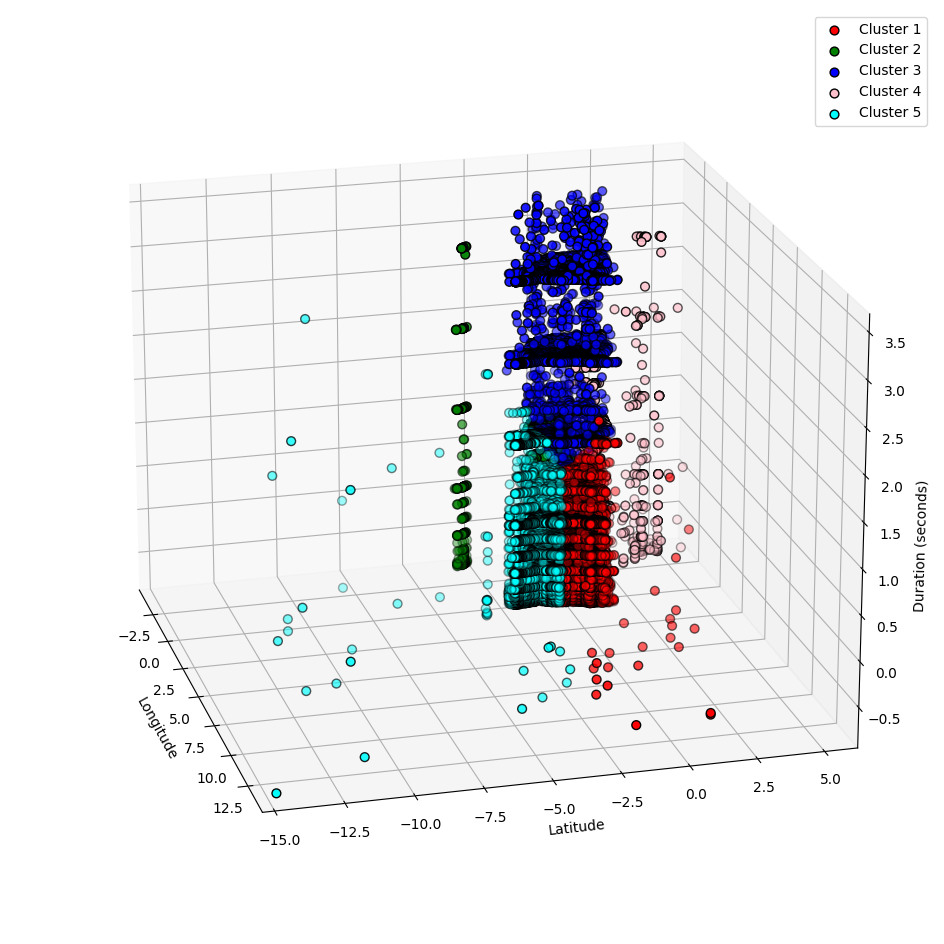

In [16]:
# First the data was seperated into each cluster
ufodata_0 = ufodata_kmeans[ufodata_kmeans.cluster==0]
ufodata_1 = ufodata_kmeans[ufodata_kmeans.cluster==1]
ufodata_2 = ufodata_kmeans[ufodata_kmeans.cluster==2]
ufodata_3 = ufodata_kmeans[ufodata_kmeans.cluster==3]
ufodata_4 = ufodata_kmeans[ufodata_kmeans.cluster==4]

# Building the plot model
ufokplot = plt.figure(figsize=(15, 12)).add_subplot(projection='3d')
ufokplot.axes.set_xlim3d(left=-4.5, right=14.2)
ufokplot.axes.set_ylim3d(bottom=-15, top=5.8)
ufokplot.axes.set_zlim3d(bottom=-.85, top=3.6)

# Each point was plotted, with each cluster being a different color
ufokplot.scatter3D(ufodata_0['longitude '], ufodata_0['latitude'], ufodata_0['duration (seconds)'], c='red', edgecolors='black', s=40, label='Cluster 1')
ufokplot.scatter3D(ufodata_1['longitude '], ufodata_1['latitude'], ufodata_1['duration (seconds)'], c='green', edgecolors='black', s=40, label='Cluster 2')
ufokplot.scatter3D(ufodata_2['longitude '], ufodata_2['latitude'], ufodata_2['duration (seconds)'], c='blue', edgecolors='black', s=40, label='Cluster 3')
ufokplot.scatter3D(ufodata_3['longitude '], ufodata_3['latitude'], ufodata_3['duration (seconds)'], c='pink', edgecolors='black', s=40, label='Cluster 4')
ufokplot.scatter3D(ufodata_4['longitude '], ufodata_4['latitude'], ufodata_4['duration (seconds)'], c='aqua', edgecolors='black', s=40, label='Cluster 5')

ufokplot.view_init(elev=20., azim=-15, roll=0)
ufokplot.set_xlabel('Longitude')
ufokplot.set_ylabel('Latitude')
ufokplot.set_zlabel('Duration (seconds)')

plt.legend()
plt.show()

With the clusters being mostly close together with no clearly distinct groupings, we decided to create a map illustrating the sightings.

In [17]:
# Mapping out sightings on map using folium

# Define valid latitude and longitude ranges for each location. May not need this but just in case there are lats/longs that are not correct. This was difficult to verify with code. i got these number through trial and error and various Googles
valid_locations = {
    'continental united states': {'latitude': (24.9559, 49.6116), 'longitude ': (-125.0011, -66.9326)},
    'alaska': {'latitude': (51.6957, 71.5231), 'longitude ': (-179.9999, -129.9944)},
    'hawaii': {'latitude': (18.0056, 28.7322), 'longitude ': (-161.7558, -154.8081)},
    'puerto rico': {'latitude': (17.8679, 18.5158), 'longitude ': (-68.0312, -65.2426)},
    'district of columbia': {'latitude': (37.4563, 38.9108), 'longitude ': (-77.1685, -76.9105)}
}

# This centers the map on the US
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5, control_scale=True)

# Define colors for the colormap
colors = ['#fee6ce', '#fdae61', '#f46d43', '#d73027']

# Create StepColormap with custom colors and ranges
cmap = StepColormap(colors, index=[0, 500, 1000, 1500], vmin=0, vmax=1440, caption='Duration (seconds)')

# Adds the colormap to the map
us_map.add_child(cmap)


# Goes through and gathers points for each entry
for index, row in ufodata.iterrows():
    # Get the latitude, longitude, and duration for each data point
    lat = row['latitude']
    lon = row['longitude ']
    duration = row['duration (seconds)']

    # Check if the data point is in valid range
    valid_range = False
    for location, ranges in valid_locations.items():
        lat_range = ranges['latitude']
        lon_range = ranges['longitude ']
        # this was a pain for me to logic but it got there
        if lat_range[0] <= lat <= lat_range[1] and lon_range[0] <= lon <= lon_range[1]:
            valid_range = True
            break

    # If the data point is within a valid range, adds a dot to the map with the color based on duration
    if valid_range:
        folium.CircleMarker(location=[lat, lon], radius=5, color='grey', fill_color=cmap(duration), fill_opacity=0.7).add_to(us_map)

# Colab will not fully display this map. 
# Luckily folium has a save to HTML feature that we can use.
# html file, uncomment out the below line(us_map) and comment out the bottom line (us_map.save('us_map.html'))
# us_map
us_map.save('us_map.html')

We also broke down the data into regions and compared violin plots to see if there were any differences in the duration of encounters based on geographical region. The violin plots turned out to be very similar.

In [18]:
# separate states into regions.
def get_us_region(state):
    """
    Returns the region in the US based on state abbreviation.
    """
    state = state.lower() # Convert state abbreviation to lowercase.
    if state in ['wa', 'or', 'id', 'mt', 'ak', 'hi']:
        return "Northwest"
    elif state in ['ca', 'nv', 'az', 'nm', 'co', 'ut', 'wy']:
        return "Southwest"
    elif state in ['nd', 'sd', 'ne', 'ks', 'ok', 'tx', 'mn', 'ia', 'mo', 'ar', 'la']:
        return "Central"
    elif state in ['wi', 'mi', 'il', 'in', 'oh', 'ky', 'tn', 'ms', 'al', 'ga', 'fl', 'sc', 'nc', 'pr']:
        return "Southeast"
    elif state in ['me', 'vt', 'nh', 'ma', 'ri', 'ct', 'ny', 'pa', 'nj', 'de', 'md', 'va', 'wv', 'dc']:
        return "Northeast"
    else:
        return "Unknown"


# Add 'Region' column to the DataFrame based on 'state' column
ufodata['Region'] = ufodata['state'].apply(lambda x: get_us_region(x.lower()))

ufodata.to_csv('ufodata_with_region_info.csv', index=False)

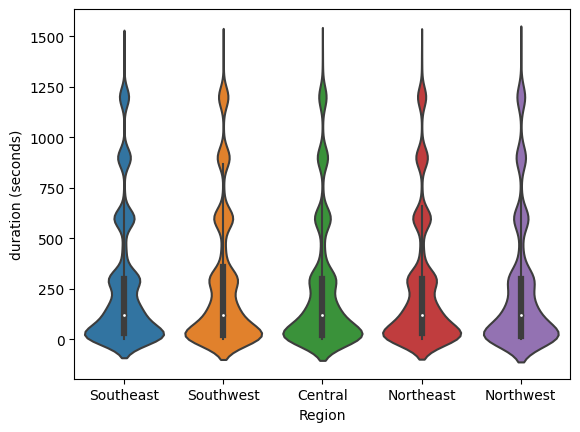

In [19]:
# show violin plots to show differences in duration by region
uforegion = pd.read_csv('/content/ufodata_with_region_info.csv')
sns.violinplot(x="Region",y="duration (seconds)",data=uforegion)
plt.show()

**...and Interpretation**
<br>Overall, our interpretation of the data is that there wasn't actually much of a relationship between the duration and location of the sightings in the United States. It turns out that the duration of sightings is pretty equal throughout the regions. The map also did not show any unusual clustering that could not be explained by population and did not really reveal any "hot spots". Sometimes, finding there is no correlation between data points can be just as important as finding one.

**Evaluation of Model Strength**
<br>Because clustering analysis does not measure data against a "truth" or a goal, there is not a solid metric to evaluate the strength of our model. In determining the best number of clusters, we used a scree plot or "elbow method", seen below.

[323688.21875457256, 201560.43131019417, 138426.92032683128, 92765.76467220907, 58819.06028299927, 52553.4074263479, 49290.71003249333, 45964.69319755788, 43201.9814210616, 40184.36395442458]


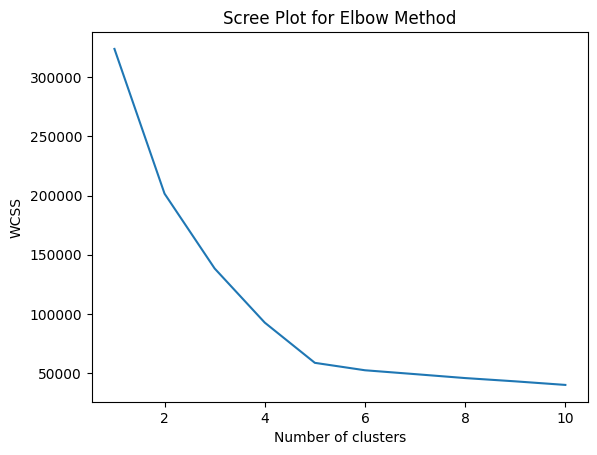

In [ ]:
wcss = []

for i in range(1, 11):
  ufo_km_model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  ufo_km_model.fit(ufodata_kmeans)
  wcss.append(ufo_km_model.inertia_)

print(wcss)

plt.plot(range(1, 11), wcss)
plt.title('Scree Plot for Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()